<a href="https://colab.research.google.com/github/Shafna81/fakenewsdetection/blob/main/12mult_bs_16_BERT_2e_5_Adam_fake_news_50_epoch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install sentencepiece
import sentencepiece
import torch.nn.functional as F
import os
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import torch
from torch.optim import Adam
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel, BertTokenizerFast, BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import get_linear_schedule_with_warmup
import time
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 116.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.2 MB/s eta 0:00:00


In [ ]:
!pip install session-info

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.4 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=3a33326e4f0ed12bde837892e3bc40772d3c3c9ed3df0ae542f8dd7e9c886c25
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [ ]:
import session_info
session_info.show()

In [ ]:
!pip freeze > requirements.txt
!pip list --format=freeze > requirements.txt

In [ ]:
seed = 12
torch.manual_seed(seed)

In [ ]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/SKRIPSI/dataset.csv')
df.head()

,Label,Text
0,1,pertamina pemerintah kalrifikasi isu bbm naik ...
1,1,polda nusa tenggara barat mengklarifkasi kejad...
2,1,pt ultrajaya milk industry tbk mengklarifikasi...
3,1,bbksda jatim mengklarifikasi wisata alam kawah...
4,1,bmkg mataram menghimbau warga langsung percaya...


In [ ]:
# split dataset into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(df['Text'].tolist(), df['Label'].tolist(), test_size=0.2, random_state=42)

In [ ]:
# load model BERT Indonesia yang telah dilatih sebelumnya
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual

In [ ]:
dropout_rate = 0.5
model.config.hidden_dropout_prob = dropout_rate
model.config.attention_probs_dropout_prob = dropout_rate

In [ ]:
# Tokenize training texts
train_tokenized_texts = tokenizer(train_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")

# Tokenize test texts
test_tokenized_texts = tokenizer(test_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")


# Create tensors for labels
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

In [ ]:
# Bagi dataset menjadi data training dan data testing
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


train_encodings = tokenizer(train_df['Text'].tolist(), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_df['Text'].tolist(), truncation=True, padding=True, max_length=512)

# Konversi data ke dalam format tensor
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_encodings['input_ids']),
                                               torch.tensor(train_encodings['attention_mask']),
                                               torch.tensor(train_df['Label'].tolist()))

test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_encodings['input_ids']),
                                              torch.tensor(test_encodings['attention_mask']),
                                              torch.tensor(test_df['Label'].tolist()))

In [ ]:
# set device to CUDA if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
# set training parameters
optimizer = Adam(model.parameters(), lr=2e-5, eps=1e-8)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
total_steps = len(train_loader) * 2

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

loss_fn = torch.nn.CrossEntropyLoss()

#loss tiap epoch
loss_training = []
acurracy_training = []
f1_score_training = []

loss_testing = []
accuracy_testing = []
f1_score_testing = []

start_time = time.time()

for epoch in range(50):
    print('\nEpoch:', epoch+1)
    print('Training...')
    model.train()

    total_loss = 0

    for step, batch in enumerate(train_loader):
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        total_loss += loss.item()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        if step % 500 == 0 and step != 0:
            avg_train_loss = total_loss / 500
            print('Batch', step, 'of', len(train_loader), '| Average Training Loss:', avg_train_loss)
            total_loss = 0

    loss_training.append (total_loss)
    print('loss:', loss_training)


    print('Testing...')
    model.eval()

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)

    predictions = []
    true_labels = []
    total_loss = 0

    for batch in test_loader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        predictions.extend(preds.cpu().numpy().tolist())
        true_labels.extend(labels.cpu().numpy().tolist())

        total_loss += loss.item()

    loss_testing.append (total_loss)

    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    print('\nAccuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 Score:', f1)

    accuracy_testing.append(accuracy)
    f1_score_testing.append(f1)

    end_time = time.time()
    runtime = end_time - start_time

    print(f"Waktu runtime: {runtime} detik")


Epoch: 1
Training...
loss: [68.92235890030861]
Testing...

Accuracy: 0.7477477477477478
Precision: 0.6654545454545454
Recall: 0.9014778325123153
F1 Score: 0.7656903765690376
Waktu runtime: 172.46798825263977 detik

Epoch: 2
Training...
loss: [68.92235890030861, 54.07588639855385]
Testing...

Accuracy: 0.7792792792792793
Precision: 0.7215189873417721
Recall: 0.8423645320197044
F1 Score: 0.7772727272727272
Waktu runtime: 352.0087802410126 detik

Epoch: 3
Training...
loss: [68.92235890030861, 54.07588639855385, 47.761492148041725]
Testing...

Accuracy: 0.7792792792792793
Precision: 0.7215189873417721
Recall: 0.8423645320197044
F1 Score: 0.7772727272727272
Waktu runtime: 534.7987358570099 detik

Epoch: 4
Training...
loss: [68.92235890030861, 54.07588639855385, 47.761492148041725, 47.57368016242981]
Testing...

Accuracy: 0.7792792792792793
Precision: 0.7215189873417721
Recall: 0.8423645320197044
F1 Score: 0.7772727272727272
Waktu runtime: 718.0245387554169 detik

Epoch: 5
Training...
loss:

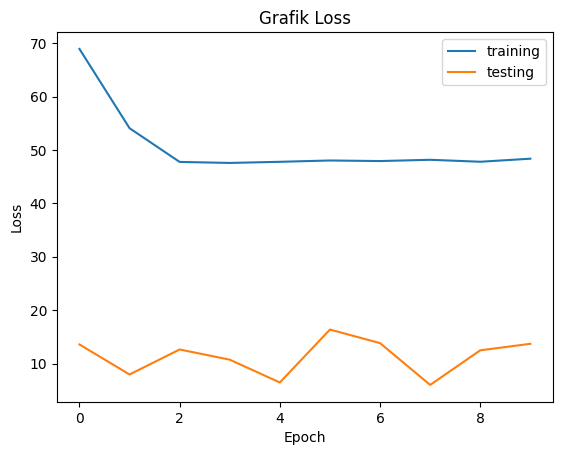

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(loss_training, label="training")
plt.plot(loss_testing, label="testing")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Grafik Loss')
plt.legend()

Text(0.5, 1.0, 'Grafik Akurasi Testing')

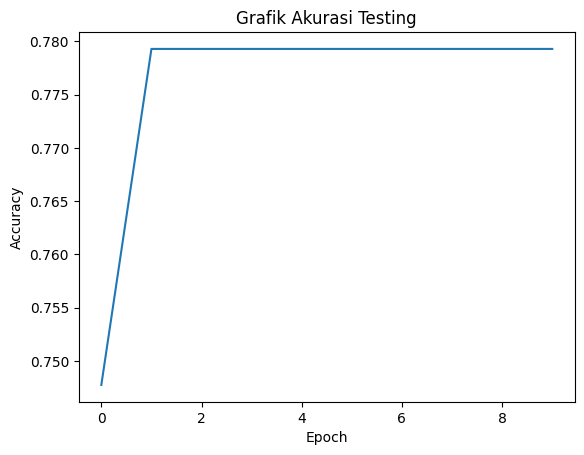

In [ ]:
plt.figure()
plt.plot(accuracy_testing)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Grafik Akurasi Testing')

Text(0.5, 1.0, 'Grafik F1 Score Testing')

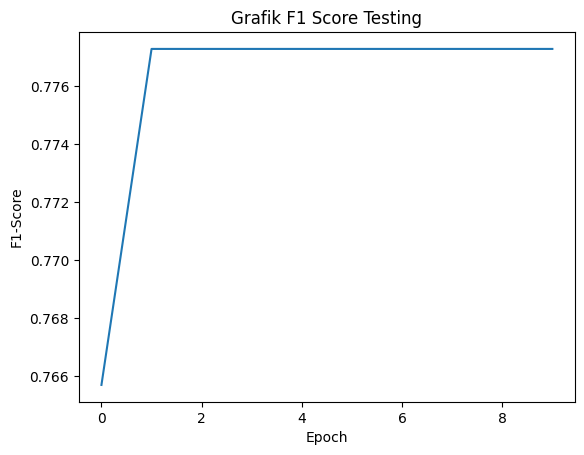

In [ ]:
plt.figure()
plt.plot(f1_score_testing)
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Grafik F1 Score Testing')

In [ ]:
tabel_hasil = pd.DataFrame(range(1, 51), columns=['ke-'])
tabel_hasil["loss_training"] = loss_training
tabel_hasil["loss_testing"] = loss_testing
tabel_hasil["accuracy"] = accuracy_testing
tabel_hasil["F1-Score"] = f1_score_testing
tabel_hasil["recall"] = accuracy_testing
tabel_hasil["precision"] = f1_score_testing

In [ ]:
tabel_hasil.head()

,ke-,loss_training,loss_testing,accuracy,F1-Score,recall,precision
0,1,68.922359,13.584611,0.747748,0.765690,0.747748,0.765690
1,2,54.075886,7.960808,0.779279,0.777273,0.779279,0.777273
2,3,47.761492,12.641630,0.779279,0.777273,0.779279,0.777273
3,4,47.573680,10.734415,0.779279,0.777273,0.779279,0.777273
4,5,47.784670,6.465103,0.779279,0.777273,0.779279,0.777273


In [ ]:
tabel_hasil.to_csv("12mult BERT datasetjibran, adam, 2e-5, bs 16, 50 epoch.csv")